# Regularization and Evaluation of Neural Networks

In [2]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [3]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [4]:
X.shape

(1797, 64)

In [5]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

2022-05-05 11:05:49.088751: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 11:05:49.089254: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


Train on 1797 samples
Epoch 1/50
1797/1797 [==============================] - 2s 1ms/sample - loss: 0.6794 - accuracy: 0.7602
Epoch 2/50
1797/1797 [==============================] - 1s 311us/sample - loss: 0.2503 - accuracy: 0.8948
Epoch 3/50
1797/1797 [==============================] - 1s 312us/sample - loss: 0.1952 - accuracy: 0.9199
Epoch 4/50
1797/1797 [==============================] - 1s 317us/sample - loss: 0.1613 - accuracy: 0.9349
Epoch 5/50
1797/1797 [==============================] - 1s 286us/sample - loss: 0.1388 - accuracy: 0.9399
Epoch 6/50
1797/1797 [==============================] - 1s 296us/sample - loss: 0.1162 - accuracy: 0.9516
Epoch 7/50
1797/1797 [==============================] - 1s 293us/sample - loss: 0.1049 - accuracy: 0.9583
Epoch 8/50
1797/1797 [==============================] - 1s 386us/sample - loss: 0.0953 - accuracy: 0.9560
Epoch 9/50
1797/1797 [==============================] - 1s 320us/sample - loss: 0.0790 - accuracy: 0.9705
Epoch 10/50
1797/1797 [===

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [6]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [7]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Train on 1149 samples
Epoch 1/10
1149/1149 [==============================] - 1s 668us/sample - loss: 0.7636 - accuracy: 0.4961
Epoch 2/10
1149/1149 [==============================] - 0s 34us/sample - loss: 0.7470 - accuracy: 0.4961
Epoch 3/10
1149/1149 [==============================] - 0s 35us/sample - loss: 0.7341 - accuracy: 0.4961
Epoch 4/10
1149/1149 [==============================] - 0s 35us/sample - loss: 0.7238 - accuracy: 0.4961
Epoch 5/10
1149/1149 [==============================] - 0s 34us/sample - loss: 0.7158 - accuracy: 0.4961
Epoch 6/10
1149/1149 [==============================] - 0s 35us/sample - loss: 0.7095 - accuracy: 0.4961
Epoch 7/10
1149/1149 [==============================] - 0s 37us/sample - loss: 0.7047 - accuracy: 0.4961
Epoch 8/10
1149/1149 [==============================] - 0s 40us/sample - loss: 0.7011 - accuracy: 0.4961
Epoch 9/10
1149/1149 [==============================] - 0s 35us/sample - loss: 0.6982 - accuracy: 0.4961
Epoch 10/10
1149/1149 [=========

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [8]:
# dict

results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fc45e51ce90>,
 '_chief_worker_only': None,
 'params': {'batch_size': 100,
  'epochs': 10,
  'steps': 12,
  'samples': 1149,
  'verbose': 1,
  'do_validation': False,
  'metrics': ['loss', 'accuracy']},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'history': {'loss': [0.7636465154802208,
   0.7470065389538558,
   0.7341134176760574,
   0.72383324974407,
   0.7158498373417568,
   0.7095061156726901,
   0.7046901446202197,
   0.7010525192666615,
   0.69820718037968,
   0.6958810101912476],
  'accuracy': [0.49608356,
   0.49608356,
   0.49608356,
   0.49608356,
   0.49608356,
   0.49608356,
   0.49608356,
   0.49608356,
   0.49608356,
   0.49608356]}}

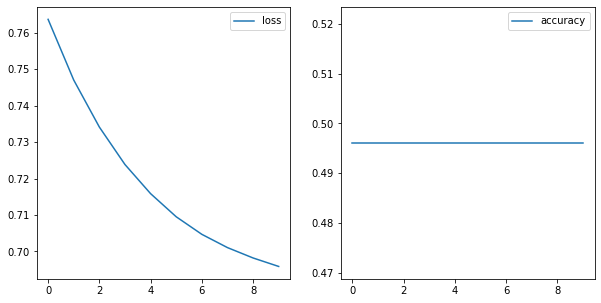

In [9]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

## Basic Model Tuning

### Increase Epochs

In [10]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)


Train on 1149 samples
Epoch 1/100
1149/1149 [==============================] - 1s 951us/sample - loss: 0.7372 - accuracy: 0.4961
Epoch 2/100
1149/1149 [==============================] - 0s 104us/sample - loss: 0.7167 - accuracy: 0.4961
Epoch 3/100
1149/1149 [==============================] - 0s 102us/sample - loss: 0.7058 - accuracy: 0.4961
Epoch 4/100
1149/1149 [==============================] - 0s 94us/sample - loss: 0.7000 - accuracy: 0.4961
Epoch 5/100
1149/1149 [==============================] - 0s 104us/sample - loss: 0.6967 - accuracy: 0.4961
Epoch 6/100
1149/1149 [==============================] - 0s 80us/sample - loss: 0.6951 - accuracy: 0.4961
Epoch 7/100
1149/1149 [==============================] - 0s 117us/sample - loss: 0.6941 - accuracy: 0.4961
Epoch 8/100
1149/1149 [==============================] - 0s 122us/sample - loss: 0.6935 - accuracy: 0.4909
Epoch 9/100
1149/1149 [==============================] - 0s 99us/sample - loss: 0.6932 - accuracy: 0.4665
Epoch 10/100
1149/

1149/1149 [==============================] - 0s 74us/sample - loss: 0.6814 - accuracy: 0.7633
Epoch 78/100
1149/1149 [==============================] - 0s 81us/sample - loss: 0.6811 - accuracy: 0.7598
Epoch 79/100
1149/1149 [==============================] - 0s 76us/sample - loss: 0.6808 - accuracy: 0.7668
Epoch 80/100
1149/1149 [==============================] - 0s 77us/sample - loss: 0.6805 - accuracy: 0.7711
Epoch 81/100
1149/1149 [==============================] - 0s 72us/sample - loss: 0.6802 - accuracy: 0.7607
Epoch 82/100
1149/1149 [==============================] - 0s 79us/sample - loss: 0.6798 - accuracy: 0.7537
Epoch 83/100
1149/1149 [==============================] - 0s 78us/sample - loss: 0.6796 - accuracy: 0.7589
Epoch 84/100
1149/1149 [==============================] - 0s 74us/sample - loss: 0.6792 - accuracy: 0.7607
Epoch 85/100
1149/1149 [==============================] - 0s 79us/sample - loss: 0.6789 - accuracy: 0.7676
Epoch 86/100
1149/1149 [==========================

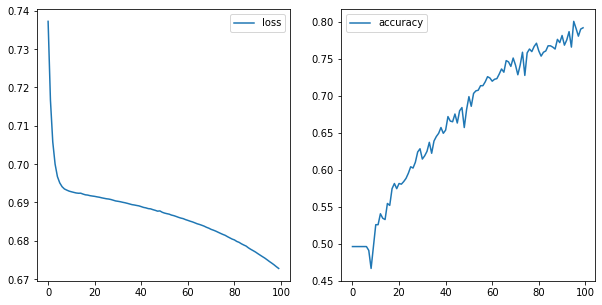

In [11]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Decrease Batch Size

In [12]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# decrease batch size

results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=10, verbose=1)

Train on 1149 samples
Epoch 1/10
1149/1149 [==============================] - 1s 1ms/sample - loss: 0.7109 - accuracy: 0.4961
Epoch 2/10
1149/1149 [==============================] - 0s 259us/sample - loss: 0.6951 - accuracy: 0.4822
Epoch 3/10
1149/1149 [==============================] - 0s 361us/sample - loss: 0.6926 - accuracy: 0.4943
Epoch 4/10
1149/1149 [==============================] - 0s 285us/sample - loss: 0.6915 - accuracy: 0.5553
Epoch 5/10
1149/1149 [==============================] - 0s 304us/sample - loss: 0.6907 - accuracy: 0.5849
Epoch 6/10
1149/1149 [==============================] - 0s 267us/sample - loss: 0.6898 - accuracy: 0.5718
Epoch 7/10
1149/1149 [==============================] - 0s 257us/sample - loss: 0.6888 - accuracy: 0.5753
Epoch 8/10
1149/1149 [==============================] - 0s 274us/sample - loss: 0.6882 - accuracy: 0.5979
Epoch 9/10
1149/1149 [==============================] - 0s 303us/sample - loss: 0.6872 - accuracy: 0.5988
Epoch 10/10
1149/1149 [===

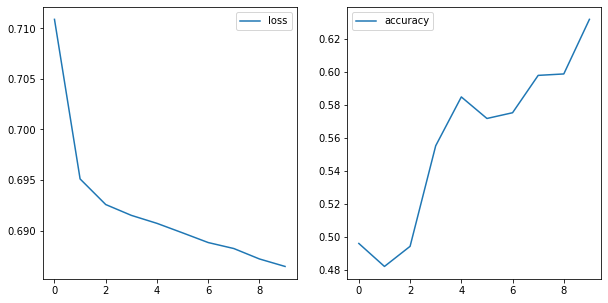

In [13]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Both

In [14]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# increase epochs decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Train on 1149 samples
Epoch 1/100
1149/1149 [==============================] - 1s 1ms/sample - loss: 0.6899 - accuracy: 0.5596
Epoch 2/100
1149/1149 [==============================] - 0s 256us/sample - loss: 0.6878 - accuracy: 0.5997
Epoch 3/100
1149/1149 [==============================] - 0s 270us/sample - loss: 0.6867 - accuracy: 0.5918
Epoch 4/100
1149/1149 [==============================] - 0s 305us/sample - loss: 0.6857 - accuracy: 0.6641
Epoch 5/100
1149/1149 [==============================] - 0s 342us/sample - loss: 0.6844 - accuracy: 0.6353
Epoch 6/100
1149/1149 [==============================] - 0s 291us/sample - loss: 0.6833 - accuracy: 0.6797
Epoch 7/100
1149/1149 [==============================] - 0s 275us/sample - loss: 0.6819 - accuracy: 0.6867
Epoch 8/100
1149/1149 [==============================] - 0s 300us/sample - loss: 0.6807 - accuracy: 0.6762
Epoch 9/100
1149/1149 [==============================] - 0s 353us/sample - loss: 0.6792 - accuracy: 0.6606
Epoch 10/100
1149

1149/1149 [==============================] - 0s 278us/sample - loss: 0.2912 - accuracy: 0.8877
Epoch 77/100
1149/1149 [==============================] - 0s 261us/sample - loss: 0.2884 - accuracy: 0.8903
Epoch 78/100
1149/1149 [==============================] - 0s 227us/sample - loss: 0.2855 - accuracy: 0.8912
Epoch 79/100
1149/1149 [==============================] - 0s 239us/sample - loss: 0.2836 - accuracy: 0.8903
Epoch 80/100
1149/1149 [==============================] - 0s 234us/sample - loss: 0.2808 - accuracy: 0.8877
Epoch 81/100
1149/1149 [==============================] - 0s 275us/sample - loss: 0.2787 - accuracy: 0.8912
Epoch 82/100
1149/1149 [==============================] - 0s 273us/sample - loss: 0.2767 - accuracy: 0.8930
Epoch 83/100
1149/1149 [==============================] - 0s 243us/sample - loss: 0.2745 - accuracy: 0.8930
Epoch 84/100
1149/1149 [==============================] - 0s 236us/sample - loss: 0.2725 - accuracy: 0.8938
Epoch 85/100
1149/1149 [=================

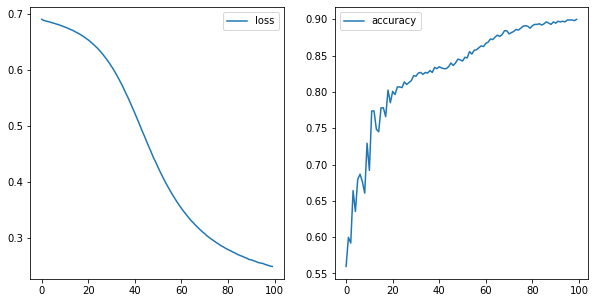

In [15]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Use Relu

In [16]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs, decrease batchsize


results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Train on 1149 samples
Epoch 1/100
1149/1149 [==============================] - 1s 968us/sample - loss: 0.6372 - accuracy: 0.6527
Epoch 2/100
1149/1149 [==============================] - 0s 302us/sample - loss: 0.5798 - accuracy: 0.7354
Epoch 3/100
1149/1149 [==============================] - 0s 294us/sample - loss: 0.5106 - accuracy: 0.7824
Epoch 4/100
1149/1149 [==============================] - 0s 267us/sample - loss: 0.4390 - accuracy: 0.8207
Epoch 5/100
1149/1149 [==============================] - 0s 281us/sample - loss: 0.3765 - accuracy: 0.8590
Epoch 6/100
1149/1149 [==============================] - 0s 293us/sample - loss: 0.3321 - accuracy: 0.8773
Epoch 7/100
1149/1149 [==============================] - 0s 312us/sample - loss: 0.3009 - accuracy: 0.8834
Epoch 8/100
1149/1149 [==============================] - 0s 345us/sample - loss: 0.2792 - accuracy: 0.8930
Epoch 9/100
1149/1149 [==============================] - 0s 349us/sample - loss: 0.2626 - accuracy: 0.8947
Epoch 10/100
11

Epoch 76/100
1149/1149 [==============================] - 0s 267us/sample - loss: 0.0471 - accuracy: 0.9887
Epoch 77/100
1149/1149 [==============================] - 0s 297us/sample - loss: 0.0456 - accuracy: 0.9904
Epoch 78/100
1149/1149 [==============================] - 0s 268us/sample - loss: 0.0454 - accuracy: 0.9887
Epoch 79/100
1149/1149 [==============================] - 0s 259us/sample - loss: 0.0454 - accuracy: 0.9826
Epoch 80/100
1149/1149 [==============================] - 0s 261us/sample - loss: 0.0444 - accuracy: 0.9869
Epoch 81/100
1149/1149 [==============================] - 0s 248us/sample - loss: 0.0411 - accuracy: 0.9896
Epoch 82/100
1149/1149 [==============================] - 0s 286us/sample - loss: 0.0377 - accuracy: 0.9939
Epoch 83/100
1149/1149 [==============================] - 0s 309us/sample - loss: 0.0389 - accuracy: 0.9896
Epoch 84/100
1149/1149 [==============================] - 0s 265us/sample - loss: 0.0390 - accuracy: 0.9922
Epoch 85/100
1149/1149 [====

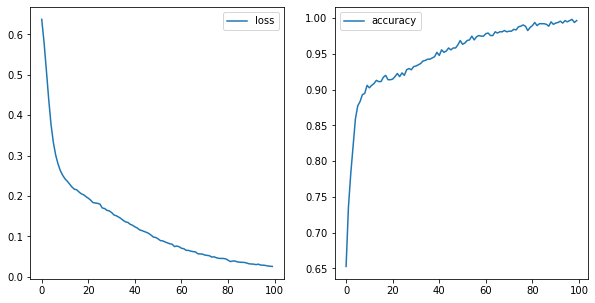

In [17]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### All of it (epochs, batch, relu)

In [ ]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs




In [ ]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Side note: learning rate

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Train on 1149 samples
Epoch 1/30
1149/1149 [==============================] - 1s 1ms/sample - loss: 1.0582 - accuracy: 0.5196
Epoch 2/30
1149/1149 [==============================] - 0s 298us/sample - loss: 1.0027 - accuracy: 0.4909
Epoch 3/30
1149/1149 [==============================] - 0s 318us/sample - loss: 1.0484 - accuracy: 0.4856
Epoch 4/30
1149/1149 [==============================] - 0s 318us/sample - loss: 1.0197 - accuracy: 0.4883
Epoch 5/30
1149/1149 [==============================] - 0s 341us/sample - loss: 1.0239 - accuracy: 0.4848
Epoch 6/30
1149/1149 [==============================] - 0s 323us/sample - loss: 1.0085 - accuracy: 0.4813
Epoch 7/30
1149/1149 [==============================] - 0s 292us/sample - loss: 1.0385 - accuracy: 0.4717
Epoch 8/30
1149/1149 [==============================] - 0s 288us/sample - loss: 1.0905 - accuracy: 0.4987
Epoch 9/30
1149/1149 [==============================] - 0s 308us/sample - loss: 0.9516 - accuracy: 0.5074
Epoch 10/30
1149/1149 [===

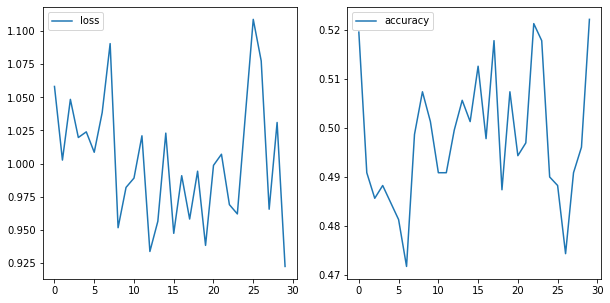

In [18]:
model = Sequential()

sgd = SGD(lr=9)


model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Train on 1149 samples, validate on 288 samples
Epoch 1/100
1149/1149 - 2s - loss: 0.6738 - accuracy: 0.5744 - val_loss: 0.6390 - val_accuracy: 0.6528
Epoch 2/100
1149/1149 - 0s - loss: 0.5964 - accuracy: 0.7258 - val_loss: 0.5406 - val_accuracy: 0.8333
Epoch 3/100
1149/1149 - 0s - loss: 0.5062 - accuracy: 0.8268 - val_loss: 0.4678 - val_accuracy: 0.8750
Epoch 4/100
1149/1149 - 0s - loss: 0.4492 - accuracy: 0.8634 - val_loss: 0.4259 - val_accuracy: 0.8854
Epoch 5/100
1149/1149 - 0s - loss: 0.4058 - accuracy: 0.8938 - val_loss: 0.3807 - val_accuracy: 0.8958
Epoch 6/100
1149/1149 - 0s - loss: 0.3747 - accuracy: 0.9060 - val_loss: 0.3612 - val_accuracy: 0.9132
Epoch 7/100
1149/1149 - 0s - loss: 0.3488 - accuracy: 0.9147 - val_loss: 0.3343 - val_accuracy: 0.9132
Epoch 8/100
1149/1149 - 0s - loss: 0.3266 - accuracy: 0.9225 - val_loss: 0.3196 - val_accuracy: 0.9236
Epoch 9/100
1149/1149 - 0s - loss: 0.3074 - accuracy: 0.9321 - val_loss: 0.2984 - val_accuracy: 0.9271
Epoch 10/100
1149/1149 - 0

Epoch 80/100
1149/1149 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.1117 - val_accuracy: 0.9757
Epoch 81/100
1149/1149 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1075 - val_accuracy: 0.9792
Epoch 82/100
1149/1149 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9757
Epoch 83/100
1149/1149 - 1s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1123 - val_accuracy: 0.9757
Epoch 84/100
1149/1149 - 1s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1098 - val_accuracy: 0.9757
Epoch 85/100
1149/1149 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.1147 - val_accuracy: 0.9757
Epoch 86/100
1149/1149 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1229 - val_accuracy: 0.9792
Epoch 87/100
1149/1149 - 1s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1155 - val_accuracy: 0.9792
Epoch 88/100
1149/1149 - 1s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1043 - val_accuracy: 0.9792
Epoch 89/100
1149/1149 - 1s - loss: 0.0041 - accuracy: 1.0000 - 

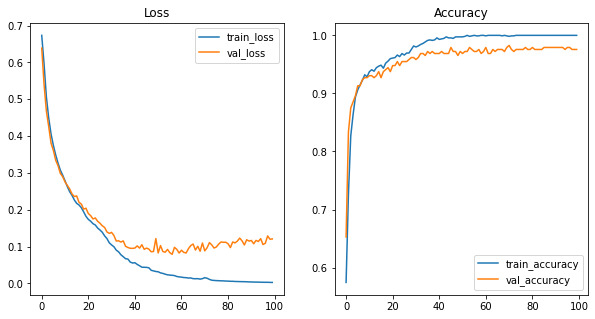

In [23]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE

results = model.fit(X_pure_train, y_pure_train, 
                    epochs=100, 
                    batch_size=10, 
                    verbose=2, 
                    validation_data=(X_val, y_val) )



train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [24]:
results.history

{'loss': [0.6737505975134794,
  0.5964112908452153,
  0.5062087099639305,
  0.44924185559270274,
  0.4057811519651438,
  0.37469002703047505,
  0.34884181963660804,
  0.3266209407123511,
  0.3074333569062493,
  0.29386710371008323,
  0.2784899655531758,
  0.2626481665747388,
  0.2488628746739048,
  0.23892743205951544,
  0.22640418660080464,
  0.21728889760865244,
  0.21279249779938406,
  0.20552868956296313,
  0.1942171216841051,
  0.18200854665305533,
  0.17372580230223084,
  0.1687670115793239,
  0.16201907841795107,
  0.15842195932272726,
  0.15026381238970785,
  0.14484971050688555,
  0.13874631242144098,
  0.1288990893176683,
  0.12154431151529309,
  0.11001154102443404,
  0.10428656676575036,
  0.09928797918158681,
  0.0901484277692694,
  0.08550964327961907,
  0.07751165270429264,
  0.07231467287562743,
  0.06682740428117796,
  0.06588857042545646,
  0.05768718602244391,
  0.05515299513903621,
  0.05591089248631289,
  0.05129970995639593,
  0.047762604978250044,
  0.04378207045

In [25]:
results.history['val_accuracy'][-1]

0.9756944

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [26]:
# This will throw an error.


model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc465110110> does not.

In [27]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

In [31]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=32,
                                          verbose=2)

In [32]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [30]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Train on 919 samples
Epoch 1/10
919/919 - 1s - loss: 0.6821 - accuracy: 0.5985
Epoch 2/10
919/919 - 0s - loss: 0.6145 - accuracy: 0.7704
Epoch 3/10
919/919 - 0s - loss: 0.5083 - accuracy: 0.8553
Epoch 4/10
919/919 - 0s - loss: 0.4033 - accuracy: 0.8705
Epoch 5/10
919/919 - 0s - loss: 0.3278 - accuracy: 0.8803
Epoch 6/10
919/919 - 0s - loss: 0.2807 - accuracy: 0.8955
Epoch 7/10
919/919 - 0s - loss: 0.2520 - accuracy: 0.8999
Epoch 8/10
919/919 - 0s - loss: 0.2299 - accuracy: 0.9129
Epoch 9/10
919/919 - 0s - loss: 0.2138 - accuracy: 0.9206
Epoch 10/10
919/919 - 0s - loss: 0.2012 - accuracy: 0.9217
230/1 - 0s - loss: 0.1938 - accuracy: 0.8652
Train on 919 samples
Epoch 1/10
919/919 - 2s - loss: 0.6830 - accuracy: 0.5647
Epoch 2/10
919/919 - 0s - loss: 0.6590 - accuracy: 0.5256
Epoch 3/10
919/919 - 0s - loss: 0.6180 - accuracy: 0.6823
Epoch 4/10
919/919 - 0s - loss: 0.5681 - accuracy: 0.7116
Epoch 5/10
919/919 - 0s - loss: 0.5260 - accuracy: 0.7987
Epoch 6/10
919/919 - 0s - loss: 0.4956 - a

array([0.86521739, 0.83913046, 0.9217391 , 0.9130435 , 0.86899561])

## [Regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

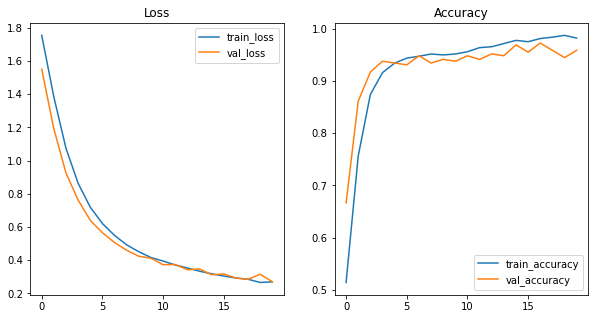

In [33]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',kernel_regularizer=l2(l=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Adding L2 to multiple layers:

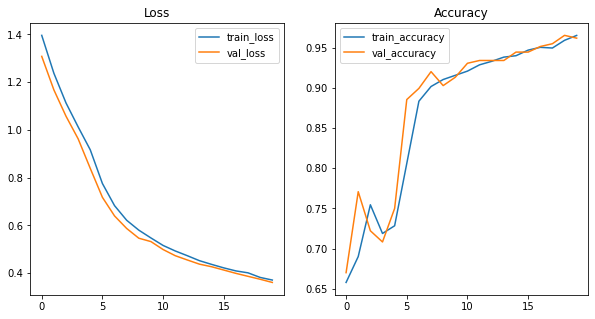

In [34]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

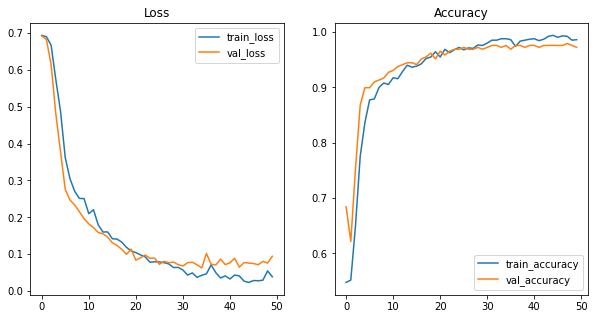

In [35]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [36]:
results.history['val_accuracy'][-1]

0.9722222

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00011: early stopping


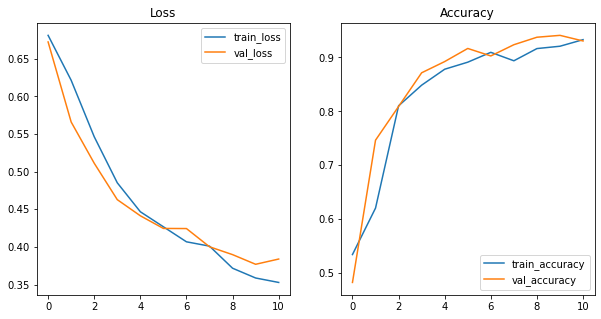

In [37]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00048: early stopping


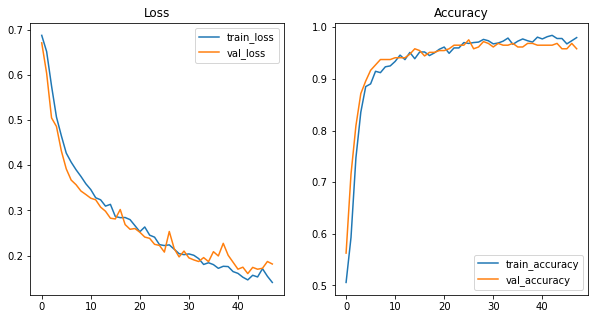

In [39]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=2, 
                           patience=5,
                           mode='min')


# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [40]:
results.history['val_accuracy'][-1]

0.9583333

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [41]:
digits = load_digits()
X = digits.data
y = digits.target

In [42]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [44]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [45]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [47]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Train on 1149 samples, validate on 288 samples
Epoch 1/50
1149/1149 [==============================] - 3s 2ms/sample - loss: 2.2075 - accuracy: 0.2376 - val_loss: 2.0900 - val_accuracy: 0.2674
Epoch 2/50
1149/1149 [==============================] - 0s 408us/sample - loss: 1.8807 - accuracy: 0.3699 - val_loss: 1.7205 - val_accuracy: 0.4340
Epoch 3/50
1149/1149 [==============================] - 0s 434us/sample - loss: 1.4583 - accuracy: 0.5483 - val_loss: 1.2876 - val_accuracy: 0.6076
Epoch 4/50
1149/1149 [==============================] - 0s 407us/sample - loss: 1.0663 - accuracy: 0.7276 - val_loss: 0.9325 - val_accuracy: 0.7431
Epoch 5/50
1149/1149 [==============================] - 0s 413us/sample - loss: 0.7754 - accuracy: 0.8355 - val_loss: 0.7060 - val_accuracy: 0.8056
Epoch 6/50
1149/1149 [==============================] - 0s 410us/sample - loss: 0.6089 - accuracy: 0.8607 - val_loss: 0.5947 - val_accuracy: 0.8403
Epoch 7/50
1149/1149 [==============================] - 0s 421us/sa

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [48]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

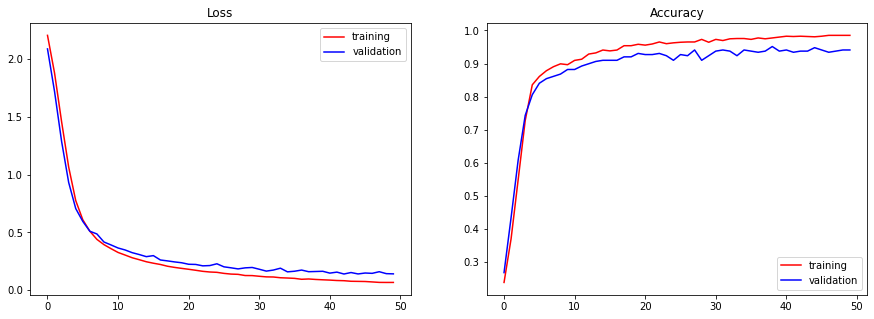

In [49]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)

ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [50]:
preds =model.predict(X_test)

In [51]:
preds[0]

array([1.8342581e-02, 4.4714328e-04, 2.4206106e-09, 5.2912724e-10,
       1.2023047e-05, 2.7309684e-04, 9.7963631e-01, 2.4563471e-10,
       1.2879629e-03, 8.4382043e-07], dtype=float32)

In [52]:
preds[0].max(), preds[0].argmax()

(0.9796363, 6)

In [53]:
X_test.shape

(360, 64)

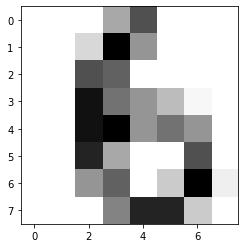

In [54]:
plt.imshow(X_test[0].reshape(8,8), cmap='Greys')

In [55]:
y_train[0]

6

In [56]:
y_test_restored = ohe.inverse_transform(y_test)
y_test_restored

array([[6],
       [9],
       [3],
       [7],
       [2],
       [1],
       [5],
       [2],
       [5],
       [2],
       [1],
       [9],
       [4],
       [0],
       [4],
       [2],
       [3],
       [7],
       [8],
       [8],
       [4],
       [3],
       [9],
       [7],
       [5],
       [6],
       [3],
       [5],
       [6],
       [3],
       [4],
       [9],
       [1],
       [4],
       [4],
       [6],
       [9],
       [4],
       [7],
       [6],
       [6],
       [9],
       [1],
       [3],
       [6],
       [1],
       [3],
       [0],
       [6],
       [5],
       [5],
       [1],
       [9],
       [5],
       [6],
       [0],
       [9],
       [0],
       [0],
       [1],
       [0],
       [4],
       [5],
       [2],
       [4],
       [5],
       [7],
       [0],
       [7],
       [5],
       [9],
       [5],
       [5],
       [4],
       [7],
       [0],
       [4],
       [5],
       [5],
       [9],
       [9],
       [0],
       [2],
    

In [58]:
y_hat = np.argmax(preds, axis=-1)
y_hat

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 3, 1, 8, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 5, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 4, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 5, 5, 6, 6, 0,
       6, 4, 2, 9, 3, 8, 7, 2, 3, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 1, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 5, 2, 5,
       5, 1, 0, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 3, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 2, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

In [59]:
confusion_matrix(y_test_restored, y_hat)

array([[31,  0,  0,  0,  1,  1,  0,  0,  0,  0],
       [ 0, 27,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  1,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  1, 32,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  0,  0,  1,  0],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  2,  1,  0,  0,  1,  0,  0, 26,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  2, 36]])

Confusion Matrix, without normalization
[[31  0  0  0  1  1  0  0  0  0]
 [ 0 27  1  0  0  0  0  0  0  0]
 [ 0  0 31  1  0  0  0  0  1  0]
 [ 0  0  1 32  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  1  0]
 [ 1  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  2  1  0  0  1  0  0 26  0]
 [ 0  0  0  2  0  0  0  0  2 36]]


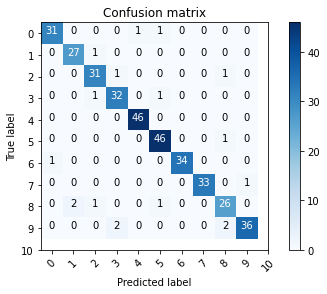

In [60]:
plot_confusion_matrix(confusion_matrix(y_test_restored, y_hat), classes=list(range(11)))

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
